In [3]:
import cython
%load_ext cython


In [5]:
import ctypes
ArrayType = type(ctypes.Array)

In [294]:
%%cython
# distutils: language = c++
# cython: cdivision = True


from libcpp.vector cimport vector

cdef extern from *:
    ctypedef int int128 "__int128_t"

def myfunc(long long a):
    cdef int128 i = a
    # set c to be the largest positive integer possible for a signed 64 bit integer
    cdef long long c = 0x7fffffffffffffff
    i *= c
    cdef long long b = i / c
    print(b)


In [295]:
import uuid

In [296]:
uuid_hex = uuid.uuid4().hex
uuid_bytes = uuid.UUID(uuid_hex).bytes

In [298]:
len(uuid_bytes)

16

We can embed a uuid into an array of long values. But we will have the following issue.

Note that since Long values store 8 bytes, and our uuid needs 16 bytes, the array is interpreted as having 2 elements,
instead of a single element.

In [235]:
import array
x = array.array('L', uuid_bytes)
x

array('L', [15294514873425529225, 10212525431259807118])

In [236]:
import numpy as np

In [237]:
x = np.chararray(shape=1, itemsize=128)
x[0] = uuid_bytes
x

chararray([b'\x89\tuZ>\x08A\xd4\x8e=\xe2}\xc5-\xba\x8d'], dtype='|S128')

In [238]:
np_uuids = np.array([uuid_bytes], dtype='|S128')
np_uuids

array([b'\x89\tuZ>\x08A\xd4\x8e=\xe2}\xc5-\xba\x8d'], dtype='|S128')

In [239]:
np_uuids[0]

b'\x89\tuZ>\x08A\xd4\x8e=\xe2}\xc5-\xba\x8d'

In [240]:
hex(uuid_bytes)

TypeError: 'bytes' object cannot be interpreted as an integer

In [252]:
uuid_hex = uuid.uuid4().hex
uuid_bytes = uuid.UUID(uuid_hex).bytes
array.array('u', uuid_hex)

array('u', '26cee4814b5241a78f7ac32eaab80307')

In [268]:
array.array('u')

array('u')

### DynamicArray

https://stackoverflow.com/questions/6950456/how-to-create-a-dynamic-array

In [289]:
class DynamicArray(object):
    def __init__(self):
        self._data = np.zeros(100)
        self._size = 0

    def get_data(self):
        return self._data[:self._size]

    def append(self, value):
        if len(self._data) == self._size:
            self._data = np.resize(self._data, int(len(self._data)*2))
        self._data[self._size] = value
        self._size += 1


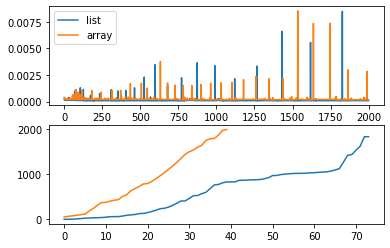

In [384]:
from array import array
import time
import numpy as np
import pylab as pl

def test_time(func):
    arrs = [func() for i in range(2000)]
    t = []
    for i in range(2000):
        start = time.time()
        for a in arrs:
            a.append(i)
        t.append(time.time()-start)
    return np.array(t)

t_list = test_time(lambda:[])
t_array = test_time(lambda:array("d"))
pl.subplot(211)
pl.plot(t_list, label="list")
pl.plot(t_array, label="array")
pl.legend()
pl.subplot(212)
pl.plot(np.where(t_list>2*np.median(t_list))[0])
pl.plot(np.where(t_array>2*np.median(t_array))[0])
pl.show()


In [305]:
x = [0]*1_000_000
x[-10] = 5

In [309]:
%%timeit
x.index(5)

9 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [320]:
x_np = np.array(x)

In [370]:
uuids = [uuid.uuid4().bytes for x in range(1_000_000)]
uuids_np = np.array(uuids, dtype='|S128')

In [372]:
uuids_np

array([b'5\x9b\x18M\x8f^C\xe9\x88\x8d\xce\xca\xf6C\x8d@',
       b'bt_$\x04\xfaM,\xa2\x1e\xc0\xd4\xbd\x14\xa8~',
       b' (\xc1\x9d\xf3\x89K\x0c\x8c\xee\xe4\x8eq\xeeP\r', ...,
       b"'\xb2\xdd[6\xdeIh\xb3\x8f\x99=^\x976!",
       b'\x83\x0b\x96N3RE=\xbf\x9f\xe2\xb2Y\x1b`\xd8',
       b'O\x83y\xc1\xd7\xa4L\xef\x89\xfb\xcd\xdc\x80\xca\xa4\xa7'],
      dtype='|S128')

In [385]:
uuids_np.dtype

dtype('S128')

In [378]:
q = uuids[-10]

In [387]:
%%timeit
uuids.index(q)

10.1 ms ± 498 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [388]:
%%timeit
np.where(uuids_np==q)

10.8 ms ± 601 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [413]:
%%cython -a
cdef int index(str[:] lst, str value):
    cdef int i
    cdef int n = len(lst)
    for i in range(n):
        if lst[i] == value:
            return i

In [415]:
index(uuids, q)

999990

In [416]:
%%timeit
index(uuids, q)

11.9 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [439]:
uuids_np.dtype

dtype('S128')

Let´s cast as 128 bit integers

In [466]:
uuids = [uuid.uuid4().hex for x in range(1_000_000)]
uuids_np = np.array(uuids, dtype=np.long)

/var/folders/lh/njnz5hj934d2js334v28z1x00000gn/T/ipykernel_7681/333225625.py:2: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uuids_np = np.array(uuids, dtype=np.long)


ValueError: invalid literal for int() with base 10: '88bba686113046d2a24bec0e469708aa'

In [498]:
uuid_as_int = np.compat.long(uuids[0], base=16)

In [500]:
bin(uuid_as_int)

'0b10001000101110111010011010000110000100010011000001000110110100101010001001001011111011000000111001000110100101110000100010101010'

In [544]:
uuid_as_int = np.int(uuids[0], base=16)

/var/folders/lh/njnz5hj934d2js334v28z1x00000gn/T/ipykernel_7681/1973026324.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  uuid_as_int = np.int(uuids[0], base=16)


In [545]:
np.uint64

numpy.uint64

In [548]:
np.array(uuids[0], dtype=np.ulonglong, base=16)

TypeError: array() got an unexpected keyword argument 'base'

In [549]:
np.ulonglong(uuids[0])

ValueError: invalid literal for int() with base 10: '88bba686113046d2a24bec0e469708aa'

In [552]:
uuid_as_int 

181749344441182162627633700916627441834

In [494]:
uuids_np = np.compat.long(uuids[, base=16)

TypeError: int() can't convert non-string with explicit base

In [462]:
%%cython -a
ctypedef unsigned long long int128
cimport cython


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef int index_128bit(int128[:]  lst, int128 value):
    cdef int i
    cdef int n = len(lst)
    for i in range(n):
        if lst[i] == value:
            return i

In [458]:
index_128bit(uuids_np,q) 

ValueError: Buffer dtype mismatch, expected 'int128' but got a string

In [460]:
uuids_np.asarray

SyntaxError: invalid syntax (2593094190.py, line 1)

In [361]:
%%cython
def index(bytes[:] lst, bytes value):
    cdef int i
    for i in range(len(lst)):
        if lst[i] == value:
            return i
    raise ValueError

In [362]:
type(q)

numpy.bytes_

In [363]:
index(uuids_np,q)

ValueError: Buffer dtype mismatch, expected 'bytes object' but got a string

In [157]:
uuid_bytes

b'\xc0>\xbc|D\x99@@\x9b\xb3\xba\x16\xc2\xe6\x88\xeb'

In [140]:
int_val = int.from_bytes(uuid_bytes, "big")

In [143]:
len(str(int_val))

39

In [137]:
base63uuid_bytes

b'\xc0>\xbc|D\x99@@\x9b\xb3\xba\x16\xc2\xe6\x88\xeb'